In [1]:
import sys
import random
import warnings
import numpy as np
import torch
import torch.nn as nn  # PyTorch Lightning NN (neural network) module
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, default_collate
import torch.optim as optim 
from torchdata.dataloader2 import DataLoader2
import torchdata
import pytorch_lightning as pl
from pytorch_lightning.callbacks import DeviceStatsMonitor
from ceruleanml import plot
from ceruleanml import evaluation
from ceruleanml.data_pipeline import put_image_in_dict, get_src_pths_annotations, channel_first_norm_to_tensor, stack_tensors
from transformers import AutoModelForUniversalSegmentation, OneFormerConfig
import skimage.io as skio

if not sys.warnoptions:
    warnings.simplefilter("ignore")
# Set the random seed
seed=0 # we need to set this for torch datapipe separately
random.seed(seed)

Loading the train and validation set

In [2]:
train_dir = "../data/partitions/train_tiles_context_0/"
train_imgs, train_annotations = get_src_pths_annotations(train_dir)
val_dir = "../data/partitions/val_tiles_context_0/"
val_imgs, val_annotations = get_src_pths_annotations(val_dir)
test_dir = "../data/partitions/test_tiles_context_0/"

Setting up the datapipes

In [3]:
train_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
train_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
train_source_pipe_processed = (
    train_i_coco_pipe.get_scene_paths(train_dir)  # get source items from the collection
    .read_tiff()
)

In [4]:
train_labels_pipe_processed = (
    train_l_coco_pipe.decode_masks()
)

We'll train on random crops of masks to focus on the most informative parts of scene for more efficient training.

In [5]:
train_dp = (
    train_source_pipe_processed.zip(train_labels_pipe_processed)
    .random_crop_mask_if_exists(2000,2000)
    .map(channel_first_norm_to_tensor)
    .map(stack_tensors)
)

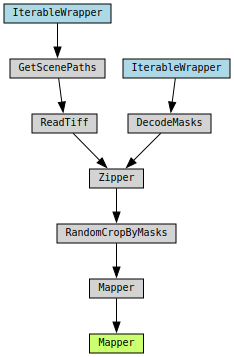

In [6]:
torchdata.datapipes.utils.to_graph(dp=train_dp)

Putting datapipes in a pytorch-lightning DataModule

In [37]:
import matplotlib.pyplot as plt
from transformers import OneFormerProcessor

def curried_amax(sample_dict_processed):
    sample_dict_processed['masks'] = torch.amax(sample_dict_processed['masks'], axis=0)
    return sample_dict_processed
class OneFormerDataModule(pl.LightningDataModule):
    def __init__(self, train_dir, val_dir, test_dir, batch_size, num_workers, crop_size=2000):
        super().__init__()
        self.train_dir, self.val_dir, self.test_dir = train_dir, val_dir, test_dir
        self.bs = batch_size
        self.num_workers = num_workers
        self.crop_size = crop_size
        self.processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny",  num_labels=3)

    def curried_processor(sample_dict_processed):
        return self.processor(images=sample_dict_processed['image'], segmentation_maps=sample_dict_processed['masks'], task_inputs=["panoptic"], return_tensors="pt")

    def setup(self, stage):
        if stage is not None:  # train/val/test/predict
            train_imgs, train_annotations = get_src_pths_annotations(self.train_dir)
            train_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
            train_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[train_annotations])
            train_source_pipe_processed = (
                train_i_coco_pipe.get_scene_paths(self.train_dir)  # get source items from the collection
                .read_tiff()
            )
            train_labels_pipe_processed = (
                train_l_coco_pipe.decode_masks()
            )
            self.train_dp = (
                train_source_pipe_processed.zip(train_labels_pipe_processed)
                .random_crop_mask_if_exists(self.crop_size, self.crop_size)
                .map(channel_first_norm_to_tensor)
                .map(stack_tensors)
            )
            # TODO if val processing mirrors train processing, this could be factored out to a func
            val_imgs, val_annotations = get_src_pths_annotations(self.val_dir)
            val_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[val_annotations])
            val_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[val_annotations])
            val_source_pipe_processed = (
                val_i_coco_pipe.get_scene_paths(self.val_dir) # get source items from the collection
                .  read_tiff()
            )
            val_labels_pipe_processed = (
                val_l_coco_pipe.decode_masks()
            )
            self.val_dp = (
                val_source_pipe_processed.zip(val_labels_pipe_processed)
                .random_crop_mask_if_exists(self.crop_size,self.crop_size)
                .map(channel_first_norm_to_tensor)
                .map(stack_tensors)
            )

            test_imgs, test_annotations = get_src_pths_annotations(self.test_dir)
            test_i_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[test_annotations])
            test_l_coco_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[test_annotations])
            test_source_pipe_processed = (
            test_i_coco_pipe.get_scene_paths(self.test_dir) # get source items from the collection
                .read_tiff()
                .map(put_image_in_dict)
                .map(channel_first_norm_to_tensor)
            )
            test_labels_pipe_processed = (
                test_l_coco_pipe.decode_masks()
            )
            self.test_dp = (
            test_source_pipe_processed.zip(test_labels_pipe_processed)
            .combine_src_label_dicts() # we don't crop for the test set TODO, do we also not crop for validation?
            .map(channel_first_norm_to_tensor)
            .map(stack_tensors)
            )

    def graph_dp(self):
        return torchdata.datapipes.utils.to_graph(dp=self.train_dp)

    def show_batch(self, channel=0):
        """
        channel 0 - vv radar
        channel 1 infra distance
        channel 2 historical vessel traffic

        """
        assert channel in [0,1,2]

        def closest_factors(n):
            factor1 = int(n**0.5)
            factor2 = n // factor1
            while factor1 * factor2 != n:
                factor1 -= 1
                factor2 = n // factor1
            return factor1, factor2

        nrows, ncols = closest_factors(self.bs)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
        
        for item, ax in zip(self.train_dp, fig.axes):
            if channel == 0:
                vv_db_units = np.log10(np.array(item["image"][channel,:,:])) * 10
            else:
                vv_db_units = np.array(item["image"][channel,:,:])
            vv_db_units[vv_db_units == -np.inf] = np.nan
            min_value = np.nanpercentile(vv_db_units, 5)
            max_value = np.nanpercentile(vv_db_units, 95)
            rescaled = (vv_db_units - min_value) / (max_value - min_value)
            im = ax.imshow(rescaled)
            
            # Create an individual colorbar for the current image
            cbar = fig.colorbar(im, ax=ax, shrink=0.7)
            
            # Set the number of ticks on the colorbar
            cbar.locator = MaxNLocator(nbins=5)
            cbar.update_ticks()

            # Format the tick labels
            tick_formatter = FuncFormatter(lambda x, pos: f'{min_value + x * (max_value - min_value):.2f}')
            cbar.ax.yaxis.set_major_formatter(tick_formatter)

        plt.tight_layout()

    def train_dataloader(self):
        # squashes the instance masks to semantic masks, prioritizing vessel, then natural, then infra
        train_dp = self.train_dp.map(curried_amax).map(self.curried_processor)
        
        return DataLoader(dataset=train_dp.batch(self.bs), batch_size=None)

    def val_dataloader(self):
        val_dp = self.val_dp.map(curried_amax).map(self.curried_processor)
        return DataLoader(dataset=val_dp.batch(self.bs), batch_size=None)

    def test_dataloader(self):
        test_dp = self.test_dp.map(curried_amax).map(self.curried_processor)
        return DataLoader(dataset=test_dp.batch(self.bs), batch_size=None)

    def predict_dataloader(self):
        test_dp = self.test_dp.map(curried_amax).map(self.curried_processor)
        return DataLoader(dataset=test_dp.batch(self.bs), batch_size=None)

In [38]:
onef_dm = OneFormerDataModule(train_dir, val_dir, test_dir, batch_size=4, num_workers=1, crop_size=2000)

In [39]:
onef_dm.setup(stage="train") #what's the purpose of stage?

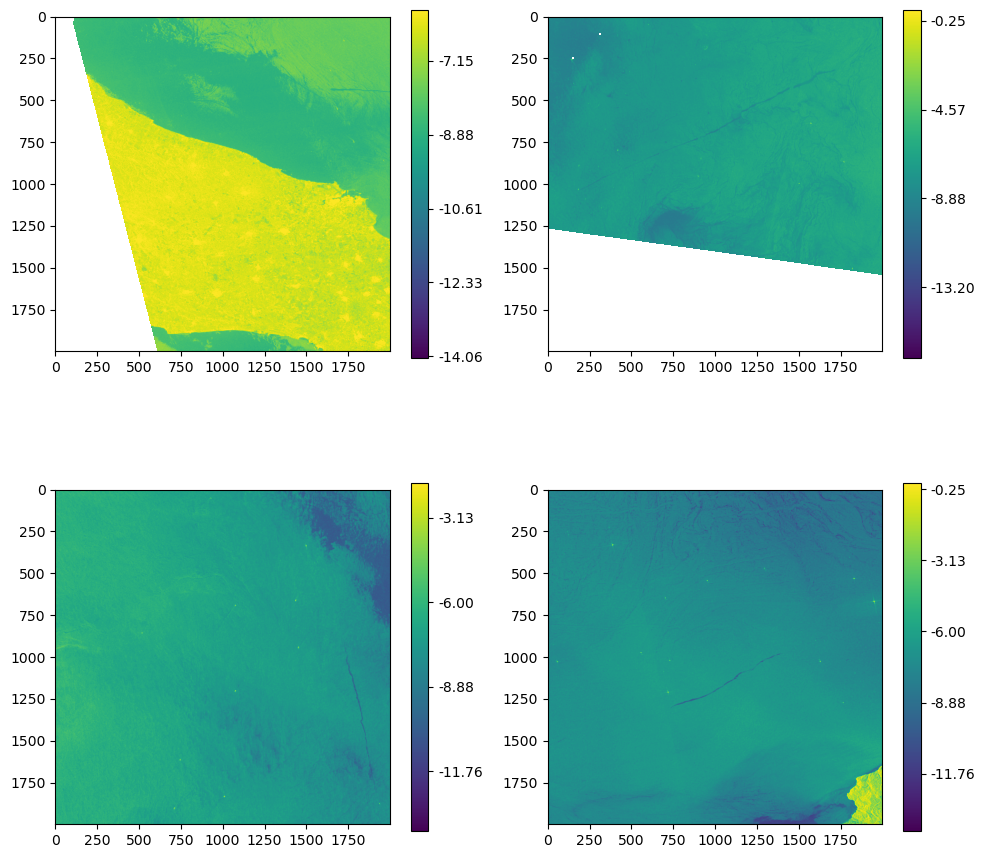

In [40]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

onef_dm.show_batch(0)

In [69]:
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
)

In [70]:
class Backbone(nn.Module):
    def __init__(
        self, model_name, in_chans, num_classes, pretrained, global_pool, drop_rate
    ):
        super().__init__()
        # loads from huggingface if not downloaded
        
        #by default the above method sets eval mode, set to training
        self.backbone.train()

    def forward(self, xb):
        return self.backbone(xb)

class OneFormerLightningModel(pl.LightningModule):
    def __init__(
        self,
        num_classes=3,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,
    ):
        super().__init__()
        self.save_hyperparameters()  # saves all hparams as self.hparams
        # this allows num_classes to differ from coco
        # https://github.com/huggingface/transformers/pull/17257/files
        self.config = OneFormerConfig.from_pretrained("shi-labs/oneformer_coco_swin_large", num_labels=num_classes, ignore_mismatched_sizes=True) 
        # can try other universal segmentation models: https://github.com/huggingface/transformers/pull/20766/files#r1050493186
        self.model = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large", config = self.config, ignore_mismatched_sizes=True)
        #by default the above method sets eval mode, set to training
        self.model.train()

    def forward(self, xb):
        return self.model(xb)

    def one_step(self, batch):
        # potential edge case, we squash instance masks to semantic masks. it's possible to lose 
        # mask label 3 from mask but not class labels since we don't edit class labels
        image_batch, mask_labels_batch, class_labels_batch = batch["pixel_values"], batch["mask_labels"], batch['class_labels']
        loss, output = self(pixel_values=image_batch, mask_labels=mask_labels_batch, class_labels=class_labels_batch)
        return loss
    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches,
        )
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        loss = self.one_step(batch)
        self.log("trn_loss", loss, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.one_step(batch)
        self.log("val_loss", loss, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        loss, score = self.one_step(batch)
        self.log("tst_loss", loss, prog_bar=True, logger=True)

In [71]:
from pytorch_lightning import LightningDataModule, LightningModule, Trainer, seed_everything

In [72]:
trainer = Trainer(
    max_epochs = 1,
    accelerator="auto",
    devices = 1 if torch.cuda.is_available else None,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [73]:
model = OneFormerLightningModel()

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_coco_swin_large and are newly initialized because the shapes did not match:
- model.transformer_module.decoder.class_embed.weight: found shape torch.Size([134, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- model.transformer_module.decoder.class_embed.bias: found shape torch.Size([134]) in the checkpoint and torch.Size([4]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([134]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
trainer.fit(model, datamodule=onef_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


ValueError: The function <bound method OneFormerDataModule.curried_processor of <__main__.OneFormerDataModule object at 0x7fb748e08bb0>> takes 0 parameters, but 1 are required.

In [ ]:
onef_dm

In [167]:
from transformers import OneFormerProcessor
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny",  num_labels=3)

panoptic_inputs = processor(images=data['image'], segmentation_maps=data['masks'], task_inputs=["panoptic"], return_tensors="pt")
for k,v in panoptic_inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
task_inputs torch.Size([1, 77])


In [174]:
from transformers import  AutoImageProcessor, MaskFormerForInstanceSegmentation
image_processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco", num_labels=3)
instance_inputs = image_processor(images=data['image'], return_tensors="pt")
for k,v in instance_inputs.items():
  print(k,v.shape)

ImportError: cannot import name 'askFormerForInstanceSegmentation' from 'transformers' (/root/mambaforge/envs/slickformer/lib/python3.10/site-packages/transformers/__init__.py)

In [173]:
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco")

NameError: name 'MaskFormerForInstanceSegmentation' is not defined

In [169]:
v

tensor([[49406,   518, 10549,   533,  1072, 24755, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

In [11]:
model = AutoModelForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_swin_large")

In [18]:
type(model)

transformers.models.oneformer.modeling_oneformer.OneFormerForUniversalSegmentation

In [19]:
dir(model.model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_auto_class',
 '_backward_compatibility_gradient_checkpointing',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_convert_head_mask_to_5d',
 '_create_repo',
 '_expand_inputs_for_generation',
 '_extract_past_from_model_output',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_from_config',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_decoder_start_token_id',
 '_get_files_timestamps',
 '_get_logits_processor',
 '_get_logits_warpe

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**panoptic_inputs)

In [ ]:

panoptic_segmentation = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(panoptic_segmentation.keys())

In [ ]:

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))
        
    ax.legend(handles=handles)
    plt.savefig('cats_panoptic.png')

draw_panoptic_segmentation(**panoptic_segmentation)

Groundtruth datapipe with non cropped images. We will use these for inference with the trained model.

In [6]:
gt_train_dp = (train_dp
                    .map(evaluation.remap_gt_dict)
                    .map(evaluation.stack_boxes)
)

In [ ]:
from torchmetrics import detection

m = detection.mean_ap.MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[.5], rec_thresholds=None, max_detection_thresholds=None, class_metrics=True)

m.update(preds=[pred_dict_thresholded_nms], target=[test_sample])

from pprint import pprint
pprint(m.compute())